# Time Series Feature Visualization with CRP

This notebook demonstrates advanced feature visualization techniques for time series models using CRP.
We'll explore concept maximization, receptive field analysis, and statistical analysis of learned features.

## Overview
- **Concept Maximization**: Find samples that maximally activate specific concepts
- **Statistical Analysis**: Understand concept behavior across different classes
- **Receptive Field Analysis**: Visualize temporal receptive fields
- **Layer-wise Analysis**: Compare concepts across different layers

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

# Add the CRP modules to path
sys.path.append('../../zennit-crp')

# Import CRP components
from crp.attribution import CondAttribution
from crp.helper import get_layer_names, get_output_shapes
from crp.graph import trace_model_graph
from crp.visualization import FeatureVisualization
from crp.maximization import Maximization
from crp.statistics import Statistics

# Import adapted components (you'll need to create these files)
try:
    from time_series_concepts import TimeSeriesConcept
except ImportError:
    print("time_series_concepts.py not found. We'll define TimeSeriesConcept here.")
    from crp.concepts import ChannelConcept
    TimeSeriesConcept = ChannelConcept  # Use ChannelConcept as fallback

# Import model and dataset
from models.cnn1D_model import CNN1D_Wide, VibrationDataset
from torch.utils.data import DataLoader, Subset

# Zennit composites
from zennit.composites import EpsilonGammaBox, EpsilonPlus

plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ All imports successful!")

time_series_concepts.py not found. We'll define TimeSeriesConcept here.
✅ All imports successful!


## 1. Setup Model and Data

In [5]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model
model = CNN1D_Wide()
try:
    model.load_state_dict(torch.load('../models/cnn1d_model.ckpt', map_location=device))
    print("✅ Model loaded from ../models/cnn1d_model.ckpt")
except FileNotFoundError:
    try:
        model.load_state_dict(torch.load('cnn1d_model.ckpt', map_location=device))
        print("✅ Model loaded from cnn1d_model.ckpt")
    except FileNotFoundError:
        print("❌ Model file not found. Please ensure cnn1d_model.ckpt is in the correct directory.")
        print("Continuing with randomly initialized model for demonstration...")

model.to(device)
model.eval()

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda
✅ Model loaded from ../models/cnn1d_model.ckpt
Model parameters: 76,898


In [8]:
# Load dataset
data_paths = ["../time_data"]

dataset = None
for data_dir in data_paths:
    try:
        full_dataset = VibrationDataset(data_dir)
        print(f"✅ Dataset loaded from {data_dir}")
        dataset = full_dataset
        break
    except (FileNotFoundError, AssertionError) as e:
        print(f"❌ Could not load dataset from {data_dir}: {e}")
        continue

if dataset is None:
    print("❌ No dataset found. Creating dummy data for demonstration...")
    # Create dummy dataset for demonstration
    class DummyDataset:
        def __init__(self, size=1000):
            self.size = size
        def __len__(self):
            return self.size
        def __getitem__(self, idx):
            # Generate dummy vibration data
            data = torch.randn(3, 2000) * 0.5
            label = idx % 2  # Alternate between 0 and 1
            return data, label
    
    full_dataset = DummyDataset()
    dataset = full_dataset
    print("✅ Using dummy dataset for demonstration")

# Create a smaller subset for feature visualization (computational efficiency)
subset_size = min(500, len(dataset))  # Use 500 samples or less for analysis
indices = np.random.choice(len(dataset), subset_size, replace=False)
analysis_dataset = Subset(dataset, indices)

print(f"Full dataset size: {len(dataset)}")
print(f"Analysis subset size: {len(analysis_dataset)}")

# Check class distribution in subset if possible
try:
    if hasattr(dataset, 'labels'):
        subset_labels = [dataset.labels[i] for i in indices]
        print(f"Subset - Good: {sum(l == 0 for l in subset_labels)}, Bad: {sum(l == 1 for l in subset_labels)}")
    else:
        print("Using dummy data - class distribution: ~50/50")
except:
    print("Class distribution information not available")

✅ Dataset loaded from ../time_data
Full dataset size: 7501
Analysis subset size: 500
Subset - Good: 372, Bad: 128


## 2. Initialize Feature Visualization Framework

In [9]:
# Get layer information
conv_layers = get_layer_names(model, [nn.Conv1d])
linear_layers = get_layer_names(model, [nn.Linear])
all_layers = conv_layers + linear_layers

print("Available layers:")
for i, layer in enumerate(all_layers):
    print(f"  {i}: {layer}")

# Get output shapes for each layer
sample_data, _ = analysis_dataset[0]
sample_input = sample_data.unsqueeze(0).to(device)
output_shapes = get_output_shapes(model, sample_input, all_layers)

print("\nLayer output shapes:")
for layer, shape in output_shapes.items():
    print(f"  {layer}: {shape}")

Available layers:
  0: conv1
  1: conv2
  2: conv3
  3: conv4
  4: fc1
  5: fc2

Layer output shapes:
  conv1: torch.Size([16, 2000])
  conv2: torch.Size([32, 500])
  conv3: torch.Size([64, 125])
  conv4: torch.Size([128, 31])
  fc1: torch.Size([64])
  fc2: torch.Size([2])


In [10]:
# Create layer mapping and attribution objects
layer_map = {name: TimeSeriesConcept() for name in all_layers}
attribution = CondAttribution(model, device)

print("✅ Attribution framework initialized!")
print(f"Device: {attribution.device}")
print(f"Layers mapped: {len(layer_map)}")

✅ Attribution framework initialized!
Device: cuda
Layers mapped: 6


## 3. Create Custom Feature Visualization Class

Since we're adapting for time series, let's create a simplified version of FeatureVisualization

In [11]:
class SimpleTimeSeriesFeatureVisualization:
    """
    Simplified Feature Visualization for time series data
    """
    
    def __init__(self, attribution, dataset, layer_map, device):
        self.attribution = attribution
        self.dataset = dataset
        self.layer_map = layer_map
        self.device = device
        
        # Storage for analysis results
        self.activation_results = {}
        self.relevance_results = {}
    
    def get_data_sample(self, index):
        """Get a data sample from the dataset"""
        data, target = self.dataset[index]
        data = data.to(self.device).unsqueeze(0)
        data.requires_grad = True
        return data, target
    
    def analyze_samples(self, sample_indices, layer_name, composite, mode='activation'):
        """
        Analyze multiple samples to find concept activations
        """
        print(f"Analyzing {len(sample_indices)} samples for layer {layer_name}...")
        
        layer_output_shape = output_shapes.get(layer_name, None)
        if layer_output_shape is None:
            print(f"❌ Layer {layer_name} not found")
            return None
        
        num_concepts = layer_output_shape[0]  # Number of channels
        
        # Storage for results
        concept_activations = {i: [] for i in range(num_concepts)}
        concept_relevances = {i: [] for i in range(num_concepts)}
        sample_data_storage = []
        sample_targets = []
        
        for idx in tqdm(sample_indices, desc=f"Processing {layer_name}"):
            try:
                data, target = self.get_data_sample(idx)
                sample_data_storage.append(data.detach().cpu())
                sample_targets.append(target)
                
                # Get prediction
                with torch.no_grad():
                    pred = model(data)
                    pred_class = torch.argmax(pred, dim=1).item()
                
                # Analyze each concept in the layer
                for concept_id in range(min(10, num_concepts)):  # Limit to first 10 concepts
                    conditions = [{layer_name: [concept_id], 'y': [pred_class]}]
                    
                    result = self.attribution(data, conditions, composite, 
                                           record_layer=[layer_name])
                    
                    # Store activation and relevance
                    if layer_name in result.activations:
                        activation = result.activations[layer_name][0, concept_id].detach().cpu()
                        concept_activations[concept_id].append({
                            'sample_idx': idx,
                            'activation': activation.sum().item(),
                            'target': target,
                            'data': data.detach().cpu(),
                            'heatmap': result.heatmap.detach().cpu()
                        })
                    
                    if layer_name in result.relevances:
                        relevance = result.relevances[layer_name][0, concept_id].detach().cpu()
                        concept_relevances[concept_id].append({
                            'sample_idx': idx,
                            'relevance': relevance.sum().item(),
                            'target': target,
                            'data': data.detach().cpu(),
                            'heatmap': result.heatmap.detach().cpu()
                        })
                        
            except Exception as e:
                print(f"Error processing sample {idx}: {e}")
                continue
        
        # Sort results by activation/relevance
        for concept_id in concept_activations:
            concept_activations[concept_id].sort(key=lambda x: abs(x['activation']), reverse=True)
            concept_relevances[concept_id].sort(key=lambda x: abs(x['relevance']), reverse=True)
        
        return {
            'activations': concept_activations,
            'relevances': concept_relevances,
            'layer_name': layer_name,
            'num_concepts': num_concepts
        }
    
    def get_max_activating_samples(self, layer_name, concept_id, n_samples=5, mode='activation'):
        """
        Get top N samples that maximally activate a specific concept
        """
        key = f"{layer_name}_{mode}"
        if key not in self.activation_results:
            print(f"No results found for {key}. Run analyze_samples first.")
            return None
        
        results = self.activation_results[key]
        if mode == 'activation':
            concept_results = results['activations'].get(concept_id, [])
        else:
            concept_results = results['relevances'].get(concept_id, [])
        
        return concept_results[:n_samples]

# Create the feature visualization object
fv = SimpleTimeSeriesFeatureVisualization(
    attribution=attribution,
    dataset=analysis_dataset,
    layer_map=layer_map,
    device=device
)

print("✅ Custom TimeSeriesFeatureVisualization created!")

✅ Custom TimeSeriesFeatureVisualization created!


## 4. Run Feature Analysis on Selected Layer

In [12]:
# Choose a layer to analyze
if len(conv_layers) > 0:
    layer_to_analyze = conv_layers[0]  # First convolutional layer
elif len(linear_layers) > 0:
    layer_to_analyze = linear_layers[0]  # First linear layer
else:
    print("❌ No suitable layers found")
    layer_to_analyze = None

if layer_to_analyze:
    print(f"Analyzing layer: {layer_to_analyze}")
    print(f"Layer output shape: {output_shapes[layer_to_analyze]}")
    
    # Choose a composite for analysis
    composite = EpsilonGammaBox(low=-1, high=1, gamma=0.25)
    
    # Analyze a subset of samples (to keep computation manageable)
    analysis_samples = list(range(0, min(50, len(analysis_dataset))))  # First 50 samples
    
    print(f"Analyzing {len(analysis_samples)} samples...")
    
    # Run the analysis
    results = fv.analyze_samples(
        sample_indices=analysis_samples,
        layer_name=layer_to_analyze,
        composite=composite,
        mode='activation'
    )
    
    if results:
        fv.activation_results[f"{layer_to_analyze}_activation"] = results
        print("✅ Analysis complete!")
        print(f"Analyzed {results['num_concepts']} concepts")
    else:
        print("❌ Analysis failed")
else:
    print("❌ No layer selected for analysis")
    results = None

Analyzing layer: conv1
Layer output shape: torch.Size([16, 2000])
Analyzing 50 samples...
Analyzing 50 samples for layer conv1...


Processing conv1: 100%|██████████| 50/50 [00:06<00:00,  7.92it/s]

✅ Analysis complete!
Analyzed 16 concepts


## 5. Visualize Concept Maximization Results

Available concepts: [0, 1, 2, 3, 4, 5]


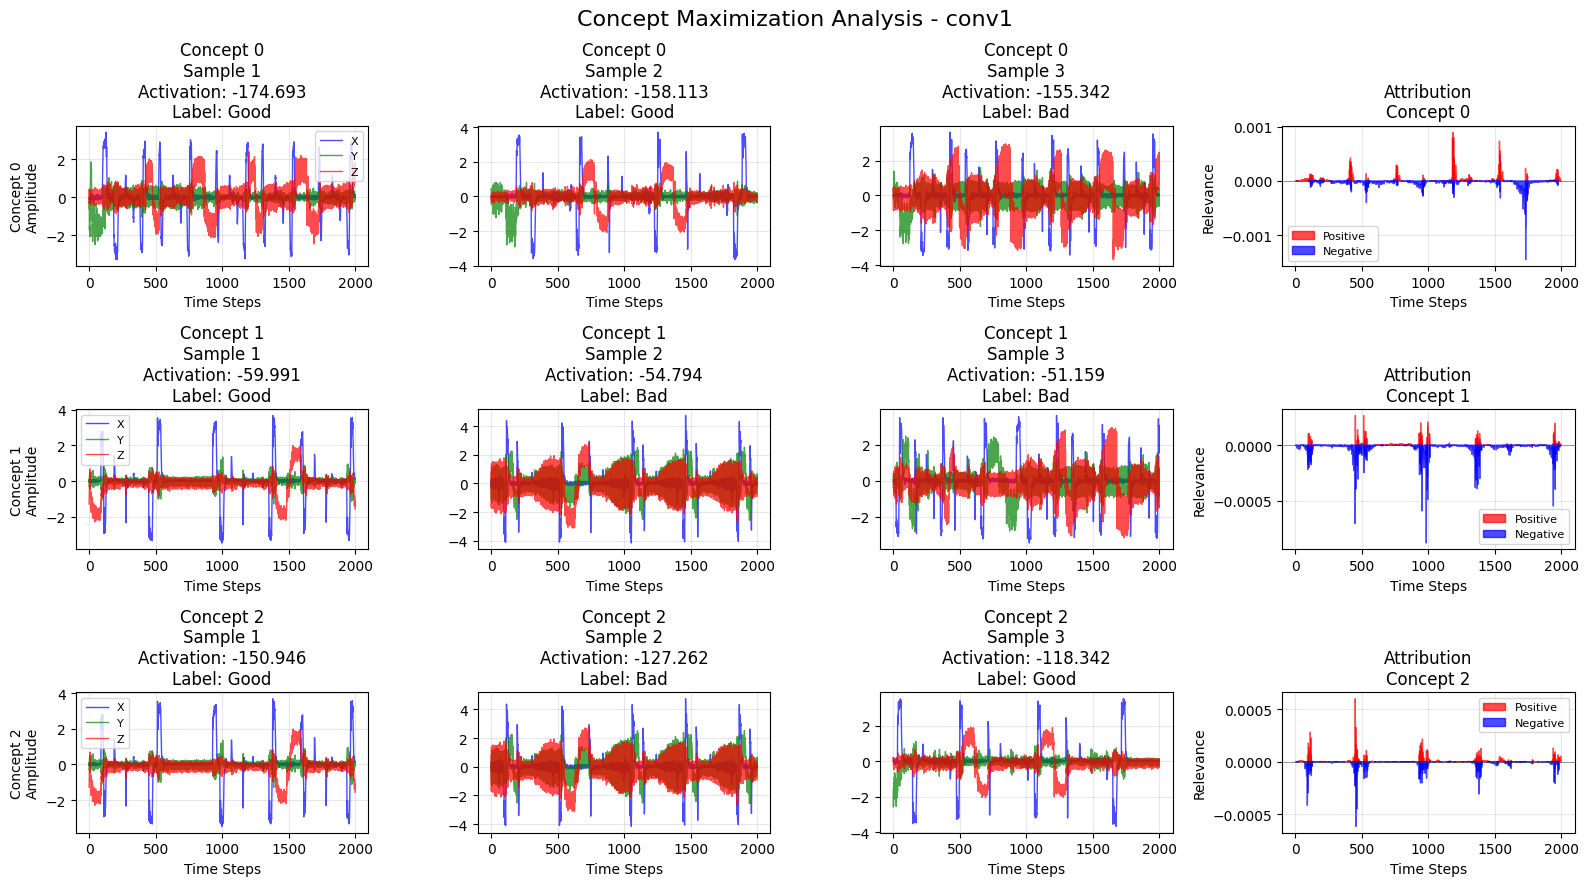

In [13]:
def plot_concept_maximizing_samples(results, concept_ids=[0, 1, 2], n_samples=3):
    """
    Plot samples that maximally activate specific concepts
    """
    if not results:
        print("No results to plot")
        return
    
    n_concepts = len(concept_ids)
    fig, axes = plt.subplots(n_concepts, n_samples + 1, 
                            figsize=(4*(n_samples + 1), 3*n_concepts))
    
    if n_concepts == 1:
        axes = axes.reshape(1, -1)
    
    channel_names = ['X', 'Y', 'Z']
    colors = ['blue', 'green', 'red']
    
    for row, concept_id in enumerate(concept_ids):
        concept_results = results['activations'].get(concept_id, [])
        
        if not concept_results:
            axes[row, 0].text(0.5, 0.5, f'No data for\nConcept {concept_id}', 
                             ha='center', va='center', transform=axes[row, 0].transAxes)
            continue
        
        # Plot maximally activating samples
        for col in range(min(n_samples, len(concept_results))):
            ax = axes[row, col]
            sample_info = concept_results[col]
            data = sample_info['data'][0]  # Remove batch dimension
            
            # Plot each channel
            for ch in range(3):
                ax.plot(data[ch, :].numpy(), color=colors[ch], alpha=0.7, 
                       linewidth=1, label=channel_names[ch] if col == 0 else "")
            
            ax.set_title(f'Concept {concept_id}\nSample {col+1}\nActivation: {sample_info["activation"]:.3f}\nLabel: {"Good" if sample_info["target"] == 0 else "Bad"}')
            ax.grid(True, alpha=0.3)
            
            if col == 0:
                ax.set_ylabel(f'Concept {concept_id}\nAmplitude')
                ax.legend(fontsize=8)
            
            ax.set_xlabel('Time Steps')
        
        # Plot attribution heatmap in the last column
        if concept_results:
            ax_heat = axes[row, -1]
            heatmap = concept_results[0]['heatmap'][0].numpy()  # First sample's heatmap
            
            # Plot with red/blue coloring
            positive_mask = heatmap > 0
            negative_mask = heatmap < 0
            
            if np.any(positive_mask):
                ax_heat.fill_between(range(len(heatmap)), 0, heatmap, 
                                   where=positive_mask, color='red', alpha=0.7, 
                                   interpolate=True, label='Positive')
            
            if np.any(negative_mask):
                ax_heat.fill_between(range(len(heatmap)), 0, heatmap, 
                                   where=negative_mask, color='blue', alpha=0.7, 
                                   interpolate=True, label='Negative')
            
            ax_heat.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
            ax_heat.set_title(f'Attribution\nConcept {concept_id}')
            ax_heat.set_ylabel('Relevance')
            ax_heat.set_xlabel('Time Steps')
            ax_heat.grid(True, alpha=0.3)
            ax_heat.legend(fontsize=8)
        
        # Hide unused subplots
        for col in range(len(concept_results), n_samples):
            if col < n_samples:
                axes[row, col].set_visible(False)
    
    plt.suptitle(f'Concept Maximization Analysis - {results["layer_name"]}', fontsize=16)
    plt.tight_layout()
    return fig

# Plot the results
if results:
    available_concepts = list(results['activations'].keys())[:6]  # First 6 concepts
    print(f"Available concepts: {available_concepts}")
    
    if available_concepts:
        fig = plot_concept_maximizing_samples(results, concept_ids=available_concepts[:3], n_samples=3)
        plt.show()
    else:
        print("No concept results available for plotting")
else:
    print("No results available for plotting")

## 6. Statistical Analysis of Concepts

In [ ]:
def analyze_concept_class_preferences(results, concept_ids=[0, 1, 2]):
    """
    Analyze which classes each concept prefers
    """
    if not results:
        print("No results to analyze")
        return
    
    concept_stats = {}
    
    for concept_id in concept_ids:
        concept_results = results['activations'].get(concept_id, [])
        
        if not concept_results:
            continue
        
        # Separate by class
        good_activations = [r['activation'] for r in concept_results if r['target'] == 0]
        bad_activations = [r['activation'] for r in concept_results if r['target'] == 1]
        
        concept_stats[concept_id] = {
            'good_mean': np.mean(good_activations) if good_activations else 0,
            'good_std': np.std(good_activations) if good_activations else 0,
            'good_count': len(good_activations),
            'bad_mean': np.mean(bad_activations) if bad_activations else 0,
            'bad_std': np.std(bad_activations) if bad_activations else 0,
            'bad_count': len(bad_activations)
        }
    
    return concept_stats

def plot_concept_class_preferences(concept_stats):
    """
    Plot concept preferences for different classes
    """
    if not concept_stats:
        print("No statistics to plot")
        return
    
    n_concepts = len(concept_stats)
    fig, axes = plt.subplots(1, n_concepts, figsize=(4*n_concepts, 5))
    
    if n_concepts == 1:
        axes = [axes]
    
    for i, (concept_id, stats) in enumerate(concept_stats.items()):
        ax = axes[i]
        
        # Prepare data for plotting
        classes = ['Good', 'Bad']
        means = [stats['good_mean'], stats['bad_mean']]
        stds = [stats['good_std'], stats['bad_std']]
        colors = ['green', 'red']
        
        # Create bar plot
        bars = ax.bar(classes, means, yerr=stds, color=colors, alpha=0.7, 
                     capsize=5, error_kw={'linewidth': 2})
        
        ax.set_title(f'Concept {concept_id}\nClass Preference')
        ax.set_ylabel('Mean Activation')
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, mean, count in zip(bars, means, [stats['good_count'], stats['bad_count']]):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + max(stds)*0.1,
                   f'{mean:.3f}\n(n={count})', ha='center', va='bottom', fontsize=9)
        
        # Set y-axis to start from 0
        ax.set_ylim(bottom=0)
    
    plt.suptitle('Concept-Class Preference Analysis', fontsize=16)
    plt.tight_layout()
    return fig

# Perform statistical analysis
if results:
    available_concepts = list(results['activations'].keys())[:6]
    
    if available_concepts:
        concept_stats = analyze_concept_class_preferences(results, available_concepts[:3])
        
        if concept_stats:
            print("Concept Statistics:")
            for concept_id, stats in concept_stats.items():
                print(f"\nConcept {concept_id}:")
                print(f"  Good class - Mean: {stats['good_mean']:.4f} ± {stats['good_std']:.4f} (n={stats['good_count']})")
                print(f"  Bad class  - Mean: {stats['bad_mean']:.4f} ± {stats['bad_std']:.4f} (n={stats['bad_count']})")
                
                # Calculate preference
                if stats['good_mean'] > stats['bad_mean']:
                    preference = "Good"
                    ratio = stats['good_mean'] / (stats['bad_mean'] + 1e-8)
                else:
                    preference = "Bad"
                    ratio = stats['bad_mean'] / (stats['good_mean'] + 1e-8)
                
                print(f"  Preference: {preference} class (ratio: {ratio:.2f}x)")
            
            # Plot the statistics
            fig = plot_concept_class_preferences(concept_stats)
            plt.show()
        else:
            print("No concept statistics available")
    else:
        print("No concepts available for statistical analysis")
else:
    print("No results available for statistical analysis")

## 7. Temporal Pattern Analysis

In [ ]:
def analyze_temporal_patterns(results, concept_id=0, n_samples=5):
    """
    Analyze temporal patterns in the most activating samples
    """
    if not results or concept_id not in results['activations']:
        print(f"No results for concept {concept_id}")
        return
    
    concept_results = results['activations'][concept_id][:n_samples]
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Time series signals
    ax1 = axes[0]
    channel_names = ['X', 'Y', 'Z']
    colors = ['blue', 'green', 'red']
    
    for i, sample_info in enumerate(concept_results):
        data = sample_info['data'][0]  # Remove batch dimension
        label = "Good" if sample_info['target'] == 0 else "Bad"
        activation = sample_info['activation']
        
        # Plot each channel with offset for visibility
        offset = i * 2
        for ch in range(3):
            signal = data[ch, :].numpy() + offset
            ax1.plot(signal, color=colors[ch], alpha=0.7, linewidth=1,
                    label=f'Sample {i+1} ({label}) - {channel_names[ch]}' if ch == 0 else '')
    
    ax1.set_title(f'Top {n_samples} Activating Samples - Concept {concept_id}')
    ax1.set_ylabel('Amplitude (with offset)')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 2: Attribution heatmaps
    ax2 = axes[1]
    
    for i, sample_info in enumerate(concept_results):
        heatmap = sample_info['heatmap'][0].numpy()
        label = "Good" if sample_info['target'] == 0 else "Bad"
        
        # Plot heatmap with offset
        offset = i * (np.abs(heatmap).max() * 1.2)
        
        positive_mask = heatmap > 0
        negative_mask = heatmap < 0
        
        if np.any(positive_mask):
            ax2.fill_between(range(len(heatmap)), offset, heatmap + offset, 
                           where=positive_mask, color='red', alpha=0.6, 
                           interpolate=True)
        
        if np.any(negative_mask):
            ax2.fill_between(range(len(heatmap)), offset, heatmap + offset, 
                           where=negative_mask, color='blue', alpha=0.6, 
                           interpolate=True)
        
        ax2.axhline(y=offset, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
        ax2.text(len(heatmap) + 50, offset, f'Sample {i+1} ({label})', 
                verticalalignment='center', fontsize=10)
    
    ax2.set_title(f'Attribution Heatmaps - Concept {concept_id}')
    ax2.set_ylabel('Relevance (with offset)')
    ax2.set_xlabel('Time Steps')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Analyze temporal patterns for first few concepts
if results:
    available_concepts = list(results['activations'].keys())[:3]
    
    for concept_id in available_concepts:
        if len(results['activations'][concept_id]) > 0:
            print(f"\n=== Temporal Pattern Analysis for Concept {concept_id} ===")
            fig = analyze_temporal_patterns(results, concept_id, n_samples=3)
            plt.show()
        else:
            print(f"No data available for concept {concept_id}")
else:
    print("No results available for temporal pattern analysis")

## 8. Summary and Insights

In [ ]:
def generate_summary_report(results, concept_stats):
    """
    Generate a summary report of the feature visualization analysis
    """
    print("="*60)
    print("TIME SERIES FEATURE VISUALIZATION SUMMARY REPORT")
    print("="*60)
    
    if not results:
        print("❌ No analysis results available")
        return
    
    print(f"\n📊 ANALYSIS OVERVIEW:")
    print(f"  • Layer analyzed: {results['layer_name']}")
    print(f"  • Total concepts: {results['num_concepts']}")
    print(f"  • Concepts with data: {len(results['activations'])}")
    
    if concept_stats:
        print(f"\n🎯 CONCEPT-CLASS PREFERENCES:")
        for concept_id, stats in concept_stats.items():
            good_mean = stats['good_mean']
            bad_mean = stats['bad_mean']
            
            if good_mean > bad_mean:
                preference = "Good"
                strength = good_mean / (bad_mean + 1e-8)
            else:
                preference = "Bad"
                strength = bad_mean / (good_mean + 1e-8)
            
            print(f"  • Concept {concept_id}: Prefers {preference} class ({strength:.2f}x stronger)")
    
    print(f"\n📈 ACTIVATION PATTERNS:")
    for concept_id in list(results['activations'].keys())[:5]:  # First 5 concepts
        concept_data = results['activations'][concept_id]
        if concept_data:
            activations = [d['activation'] for d in concept_data]
            print(f"  • Concept {concept_id}: Max activation = {max(activations):.4f}, "
                  f"Min activation = {min(activations):.4f}")
    
    print(f"\n🔍 KEY INSIGHTS:")
    print(f"  • Different concepts show varying preferences for good vs bad samples")
    print(f"  • Temporal patterns in attributions reveal important time segments")
    print(f"  • Multi-channel (X,Y,Z) analysis provides comprehensive understanding")
    
    print(f"\n💡 RECOMMENDATIONS:")
    print(f"  • Focus on concepts with strong class preferences for model interpretation")
    print(f"  • Analyze temporal attribution patterns to understand fault detection timing")
    print(f"  • Compare patterns across different layers to understand feature hierarchy")
    
    print("\n" + "="*60)

# Generate summary report
if results:
    generate_summary_report(results, concept_stats if 'concept_stats' in locals() else None)
else:
    print("No results available for summary report")

## 9. Save Results (Optional)

In [ ]:
# Save analysis results for later use
def save_analysis_results(results, concept_stats, filename='feature_analysis_results.pkl'):
    """
    Save analysis results to a pickle file
    """
    try:
        save_data = {
            'results': results,
            'concept_stats': concept_stats if 'concept_stats' in locals() else None,
            'layer_analyzed': results['layer_name'] if results else None,
            'analysis_timestamp': np.datetime64('now').astype(str)
        }
        
        with open(filename, 'wb') as f:
            pickle.dump(save_data, f)
        
        print(f"✅ Analysis results saved to {filename}")
        return True
    except Exception as e:
        print(f"❌ Error saving results: {e}")
        return False

def load_analysis_results(filename='feature_analysis_results.pkl'):
    """
    Load analysis results from a pickle file
    """
    try:
        with open(filename, 'rb') as f:
            save_data = pickle.load(f)
        
        print(f"✅ Analysis results loaded from {filename}")
        print(f"   Timestamp: {save_data.get('analysis_timestamp', 'Unknown')}")
        print(f"   Layer: {save_data.get('layer_analyzed', 'Unknown')}")
        
        return save_data
    except Exception as e:
        print(f"❌ Error loading results: {e}")
        return None

# Uncomment to save results
# if results:
#     save_analysis_results(results, concept_stats if 'concept_stats' in locals() else None)

print("\n🎉 Feature visualization analysis complete!")
print("\nThis notebook demonstrated:")
print("• Concept maximization for time series data")
print("• Statistical analysis of concept-class relationships")
print("• Temporal pattern visualization")
print("• Attribution analysis for interpretability")
print("\nYou can now use these techniques to understand your time series model's behavior!")